In [80]:
from mne import read_epochs, set_eeg_reference, compute_rank, EpochsArray, concatenate_epochs
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

In [76]:
epochs = read_epochs('referenced_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\ah\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated


In [77]:
pinch_eps, stop_eps, rest_eps = epochs['r_pinch'].copy().crop(4.1, 7.9).get_data(), epochs['r_stop'].copy().crop(4.1, 7.9).get_data(), epochs['rest'].copy().crop(0.1,3.9).get_data()
pinch_bs, stop_bs, rest_bs = epochs['r_pinch'].copy().crop(-2, 0).get_data(), epochs['r_stop'].copy().crop(-2, 0).get_data(), epochs['rest'].copy().crop(-2,0).get_data()
pinch_eps = np.concatenate([pinch_bs, pinch_eps], axis=2)
stop_eps = np.concatenate([stop_bs, stop_eps], axis=2)
rest_eps = np.concatenate([rest_bs, rest_eps], axis=2)

pinch_eps = EpochsArray(pinch_eps, epochs['r_pinch'].info, events=epochs['r_pinch'].events, event_id=epochs['r_pinch'].event_id)
stop_eps = EpochsArray(stop_eps, epochs['r_stop'].info, events=epochs['r_stop'].events, event_id=epochs['r_stop'].event_id)
rest_eps = EpochsArray(rest_eps, epochs['rest'].info, events=epochs['rest'].events, event_id=epochs['rest'].event_id)

epochs = concatenate_epochs([pinch_eps, stop_eps, rest_eps])
epochs

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied


Number of events,47
Events,r_pinch: 16r_stop: 17rest: 14
Time range,0.000 – 5.802 sec
Baseline,off


In [92]:
ch_idx = epochs.info["ch_names"].index('T7')
ch_idx

14

Effective window size : 0.250 (s)


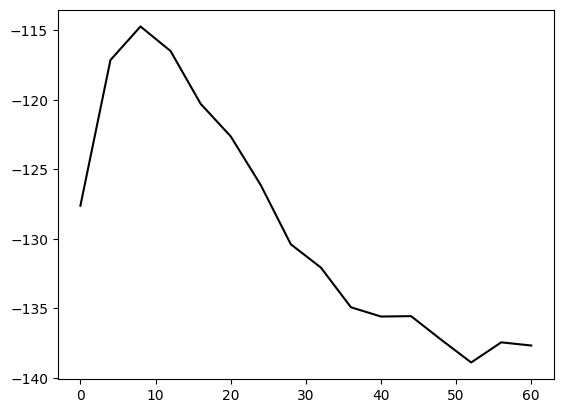

In [85]:
ch_idx = epochs.info["ch_names"].index('CP5')
spectrum = epochs.compute_psd("welch", average="mean", fmax=60)
sp_mean, freqs_mean = spectrum.get_data(return_freqs=True)
sp_mean = 10 * np.log10(sp_mean)
_, ax = plt.subplots()
ax.plot(
    freqs_mean,
    sp_mean[5, ch_idx, :],
    color="k",
    ls="-",
    label="mean of segments",
)
plt.show()
print()
spectrum

ICA

In [62]:
filtered = epochs.copy().crop(2.1,5.8).filter(1,250, n_jobs=8)
ica = ICA(n_components=12, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 2826 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 3001 out of 3008 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 3008 out of 3008 | elapsed:    5.6s finished


Fitting ICA to data using 55 channels (please be patient, this may take a while)
Selecting by number: 12 components
Fitting ICA took 7.4s.


Method,picard
Fit,45 iterations on epochs (178130 samples)
ICA components,12
Available PCA components,55
Channel types,eeg
ICA components marked for exclusion,—


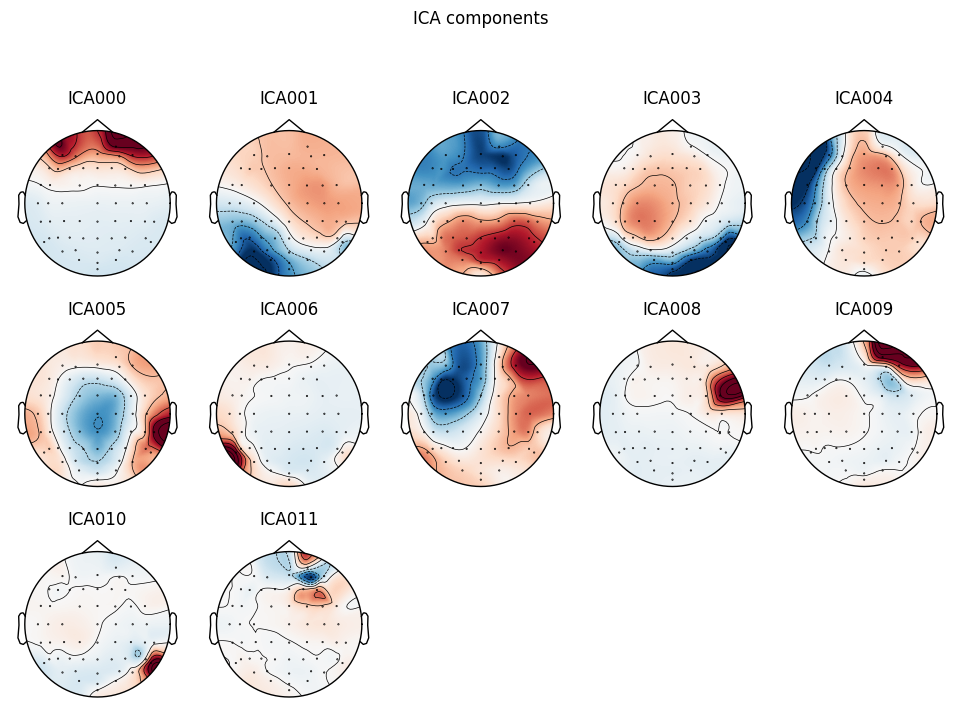

In [63]:
plot_ica_components(ica)
print()

C:\Users\Alberto\AppData\Local\Temp\ipykernel_14496\2125948803.py:2: RuntimeWarning: filter_length (3381) is longer than the signal (3278), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.copy().crop(2.1,5.3).filter(1,120, verbose=False),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
47 matching events found
No baseline correction applied
0 projection i

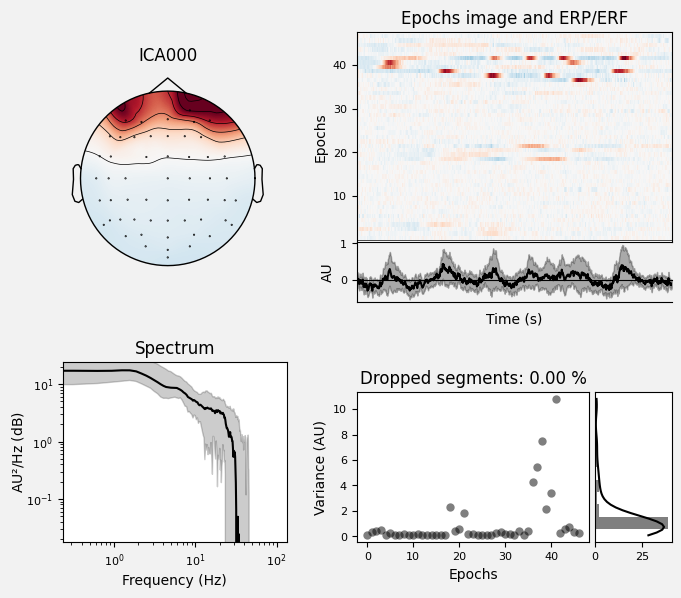

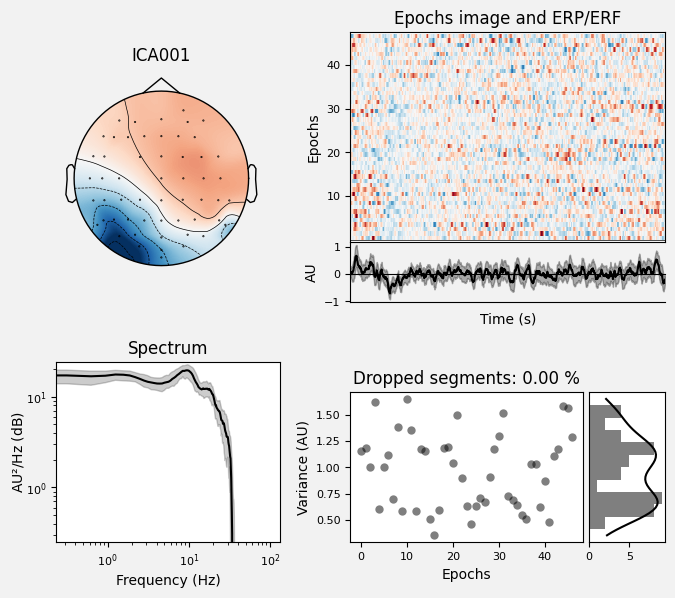

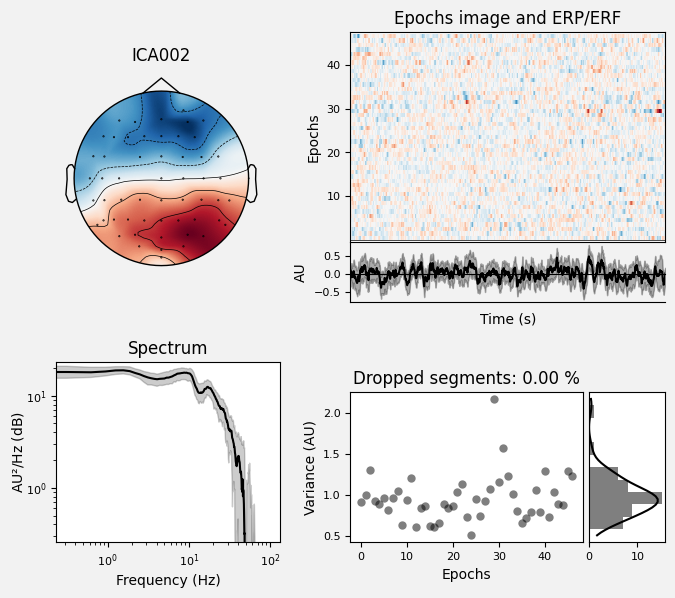

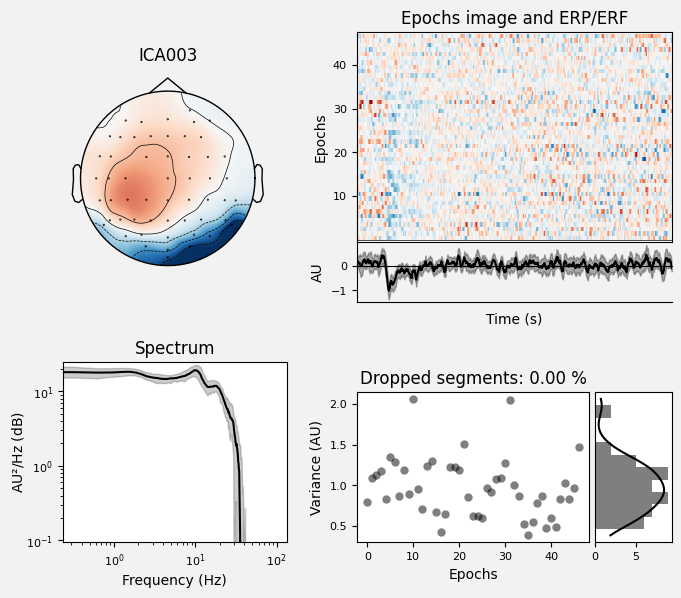

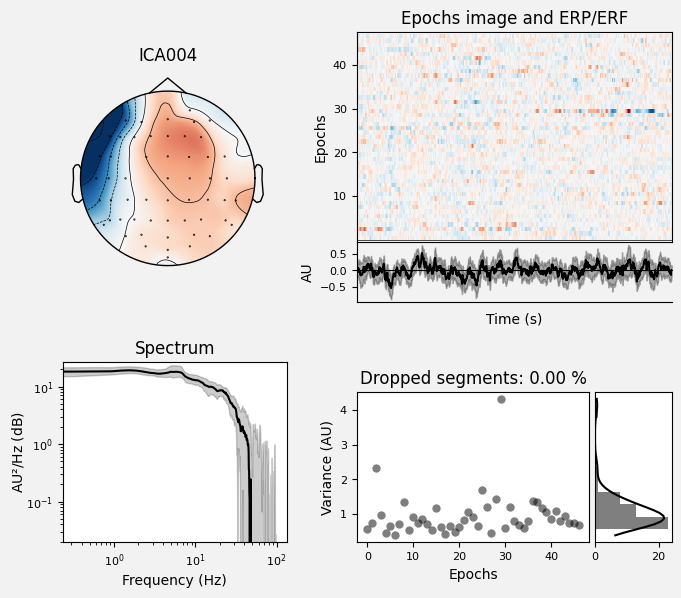

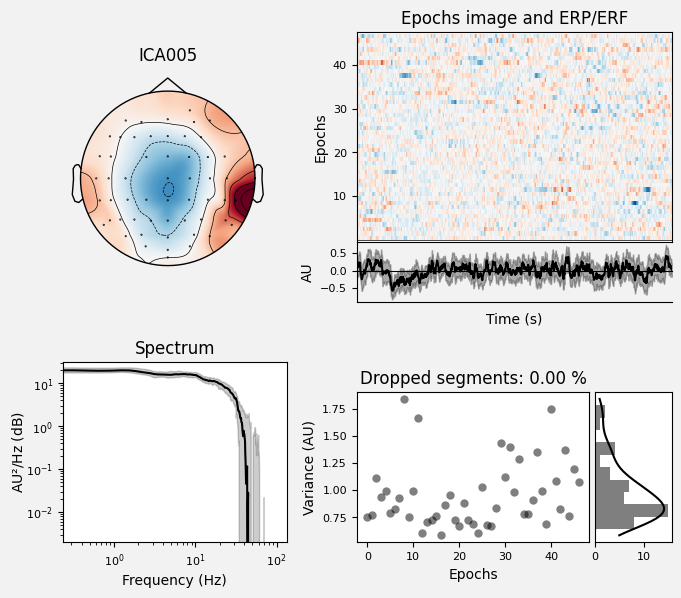

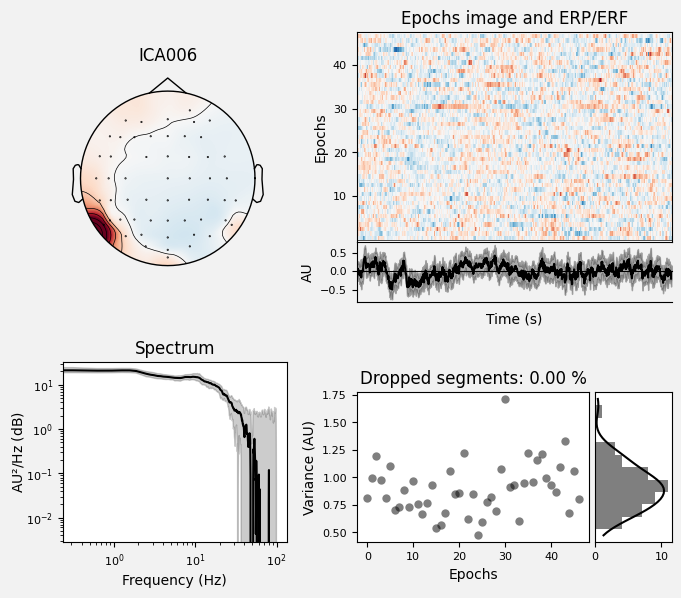

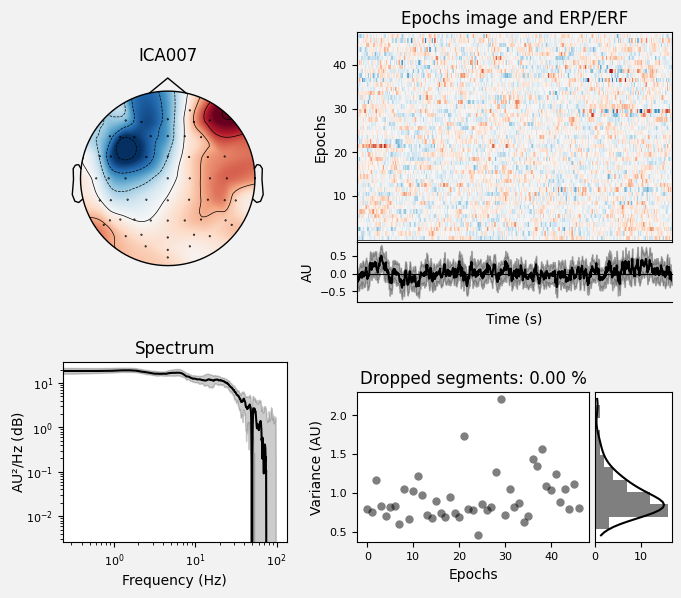

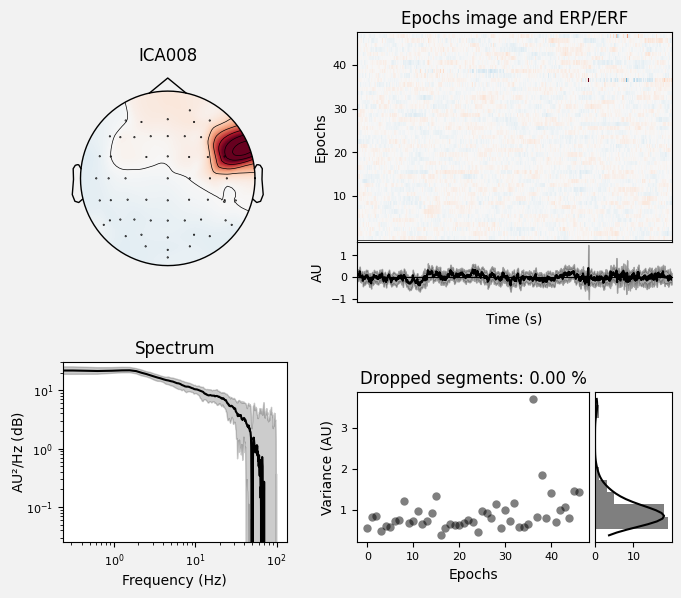

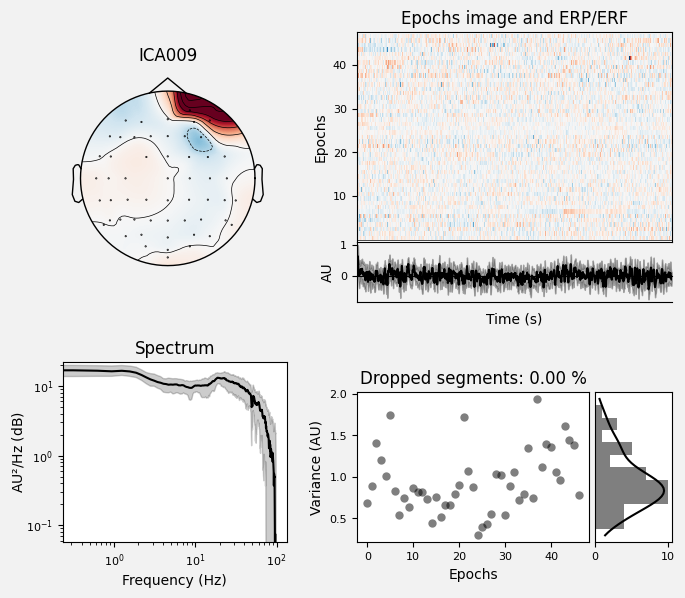

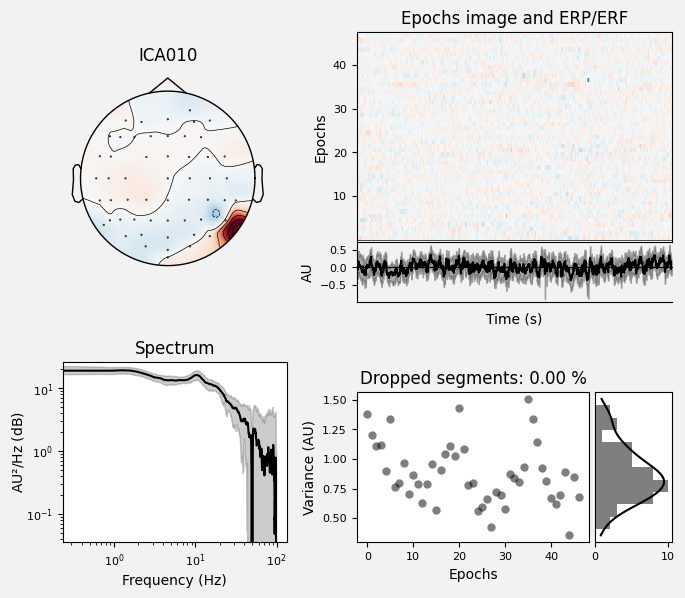

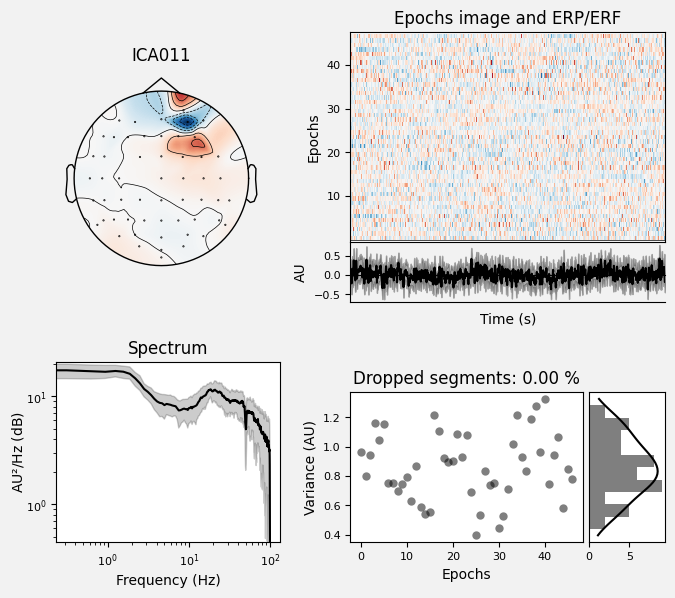

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [64]:
ica.plot_properties(
    epochs.copy().crop(2.1,5.3).filter(1,120, verbose=False), 
    picks = [0,1,2,3,4,5,6,7,8,9,10,11], 
    log_scale = True,
    psd_args = dict(fmax=100))

In [65]:
emg_eog = ['EXG1','EXG2','EXG3','EXG4','EXG6','Fpz','T8']

eog_indices, eog_scores = ica.find_bads_eog(
    filtered,
    ch_name=emg_eog, 
    measure='zscore',
    threshold=2.)

eog_indices


Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG6, Fpz, T8


[0, 4, 1, 11, 3]

Setting up band-pass filter from 1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Applying ICA to Evoked instance
    Transforming to ICA space (12 components)
    Zeroing out 10 ICA components
    Projecting back using 55 PCA components


[Parallel(n_jobs=1)]: Done 2112 out of 2112 | elapsed:    1.5s finished


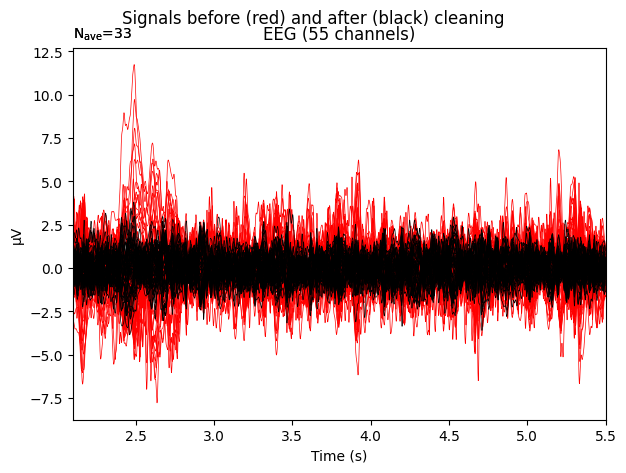

In [67]:
ica.plot_overlay(epochs['r_stop','r_pinch'].copy().crop(2.1,5.5).filter(1,60).average(), exclude=[0,1,3,4,6, 7, 8,9,10,11])
print()

In [68]:
ica.apply(epochs, exclude=[0,1,3,4,6, 7, 8,9,10,11])

Applying ICA to Epochs instance
    Transforming to ICA space (12 components)
    Zeroing out 10 ICA components
    Projecting back using 55 PCA components


Number of events,47
Events,r_pinch: 16r_stop: 17rest: 14
Time range,0.000 – 5.802 sec
Baseline,off


ERP

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1659 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2112 out of 2112 | elapsed:    1.0s finished


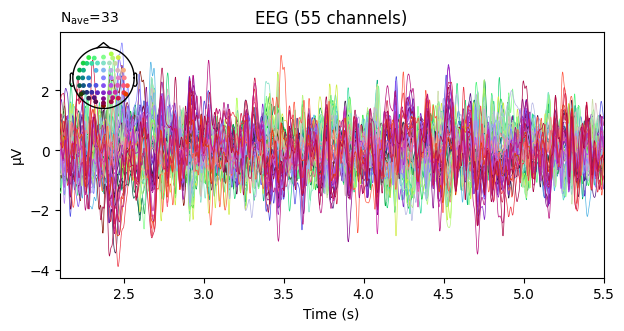

In [71]:
epochs['r_stop','r_pinch'].copy().crop(2.1,5.5).filter(1,40, n_jobs=8).average().plot()
print()

    Using multitaper spectrum estimation with 7 DPSS windows


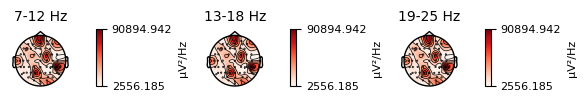

In [72]:
bands = {"7-12 Hz": (7-12), "13-18 Hz": (13-18), "19-25 Hz": (19-25)}
spectrum = epochs.copy().crop(2.1,5.5).compute_psd(fmax=120)
spectrum.plot_topomap(bands=bands, vlim="joint")
print()


In [73]:
epochs.save('rhy_epo.fif', overwrite=True)

Overwriting existing file.
